In [1]:
import json

with open('../config.json') as f:
    config = json.load(f)

In [3]:
config['env']['observation_map']

[{'type': 'rf_normal', 'bins': 20, 'mean': -0.00645789, 'std': 1.0},
 {'type': 'rf_normal', 'bins': 20, 'mean': -0.03634136, 'std': 0.53989509},
 {'type': 'rf_normal', 'bins': 20, 'mean': 0.00529333, 'std': 0.09129902},
 {'type': 'rf_normal', 'bins': 20, 'mean': 0.04752025, 'std': 0.82070579}]

In [5]:
from neurosim.game_interface import _parse_rf_map

obs_rf = [_parse_rf_map(func_def) for func_def in config['env']['observation_map']]

In [30]:
def find_boundary(idx, f, imin=None, imax=None, eps=1e-6):
    if imin == None:
        imin = -10000
    if imax == None:
        imax = 10000
        
    midpoint = imin + (imax - imin) / 2
    if f(imin).index(1.0) < idx:
        while f(midpoint).index(1.0) > idx:
            midpoint = imin + (midpoint - imin) / 2
        return find_boundary(idx, f, midpoint, imax, eps)
    if f(imax).index(1.0) > idx + 1:
        while f(midpoint).index(1.0) < idx + 1:
            midpoint = midpoint + (imax - midpoint) / 2
        return find_boundary(idx, f, imin, midpoint, eps)
    
    if imax - imin < eps:
        return round(imin, 5), imin, imax
    
    if f(midpoint).index(1.0) == idx:
        return find_boundary(idx, f, midpoint, imax, eps)
    if f(midpoint).index(1.0) == idx + 1:
        return find_boundary(idx, f, imin, midpoint, eps)
    

In [31]:
find_boundary(5, obs_rf[0])

(-0.53086, -0.5308589712091906, -0.5308583890959604)

In [33]:
space = []
for obs_idx,obs in enumerate(config['env']['observation_map']):
    obs_space = []
    for idx in range(obs['bins'] - 1):
        boundary, _, _ = find_boundary(idx, obs_rf[obs_idx])
        obs_space.append(boundary)
    space.append(obs_space)

In [ ]:
np.arrange()

In [79]:
sp = np.array(space)

import pickle as pkl

with open('obs_space.pkl', 'wb') as out:
    pkl.save(out, sp)

AttributeError: module 'pickle' has no attribute 'save'

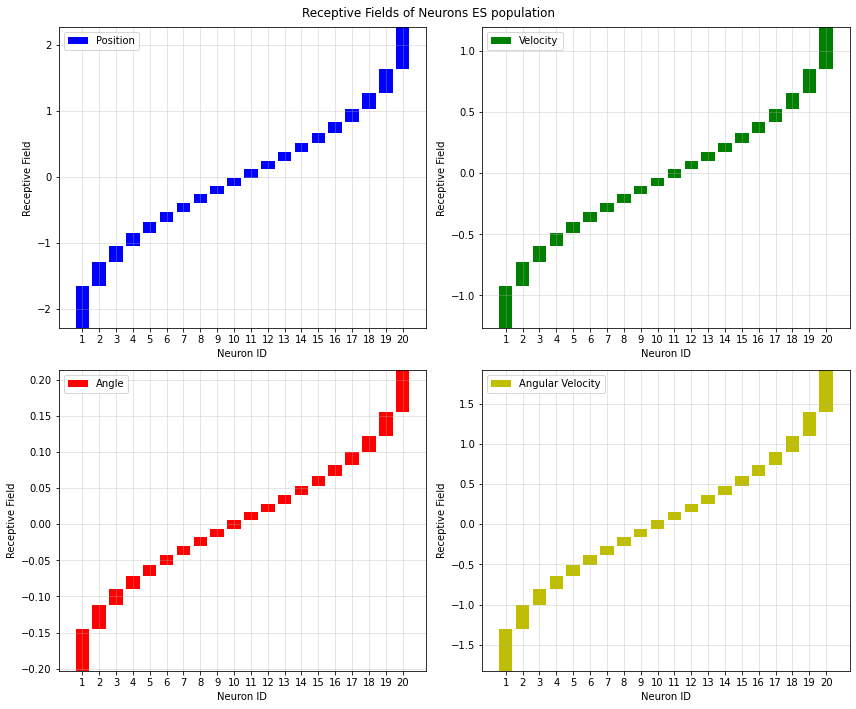

In [71]:
import numpy as np
import matplotlib.pyplot as plt

obs_names = ['Position', 'Velocity', 'Angle', 'Angular Velocity']
colors = ['b', 'g', 'r', 'y']

_,axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for idx1,axr in enumerate(axs):
    for idx2,ax in enumerate(axr):
        idx = idx1*len(axr) + idx2
        intervals = []
        d = space[idx][1] - space[idx][0]
        intervals.append([space[idx][0] - 1.75 * d, space[idx][0]])
        for si in range(len(space[idx])-1):
            intervals.append([space[idx][si], space[idx][si+1]])
        si = len(space[idx])-1
        d = space[idx][si] - space[idx][si-1]
        intervals.append([space[idx][si], space[idx][si] + 1.75 * d])


        x = np.arange(1, len(intervals)+1)
        height = [i2-i1 for i1, i2 in intervals]
        bottom = [i1 for i1, i2 in intervals]

        ax.bar(x,height, bottom=bottom, color=colors[idx])
        ax.set_ylim([min(intervals)[0], max(intervals)[1]])
        ax.set_xticks(x)
        ax.set_xlabel('Neuron ID')
        ax.set_ylabel('Receptive Field')
        ax.legend([obs_names[idx]])

        ax.grid(alpha=0.4)
        
plt.suptitle('Receptive Fields of Neurons ES population')
plt.tight_layout()
plt.show()

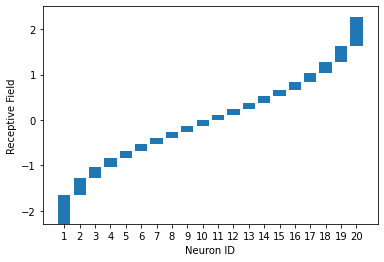

2.2741925

In [23]:
obs_rf[0](-0.47654547839024697).index(1.0)

6

In [19]:
obs_rf[0](-0.3239503162583135).index(1.0)

7

In [1]:
import os
import csv
import numpy as np

wdirs = '../results/hpsearch-2021-09-01/'
config_file = '../config.json'

run_dirs = [os.path.join(wdirs, d) for d in os.listdir(wdirs) if d.startswith('run_')]

In [3]:
from neurosim.game_interface import GameInterface
import gym
import json

class MockAIGame:
    observations = []
    rewards = []
    env = None
    def __init__(self, env):
        self.env = env

with open(config_file) as f:
    config = json.load(f)

env = gym.make('CartPole-v1')
game = MockAIGame(env)
gi = GameInterface(game, config)

In [5]:
import math
BASE = 20 # The number of neurons
OBS_CNT = 4
CNST_SUM = np.array([i*BASE for i in range(OBS_CNT)])
CNST_PROD = np.array([BASE**i for i in range(OBS_CNT)])

def obsfrind_to_obscode(obsfrind):
    assert sum([o >= BASE for o in obsfrind]) == 0
    return np.sum(obsfrind * CNST_PROD)

def obscode_to_obsfrind(obscode):
    arr = []
    curr = obscode
    for i in range(OBS_CNT):
        arr.append(curr % BASE)
        curr = math.floor(curr / BASE)
    return np.array(arr)


obs_test = [
    np.array([10, 13, 8, 7]),
    np.array([19, 19, 19, 19]),
    np.array([0, 0, 0, 0]),
    np.array([0, 1, 2, 3])]
for o in obs_test:
    assert np.sum(obscode_to_obsfrind(obsfrind_to_obscode(o)) == o) == 4
    
MAX_OBS = obsfrind_to_obscode(np.array([19, 19, 19, 19])) + 1
print('MAX_OBS', MAX_OBS)

MAX_OBS 160000


In [6]:
SPACE = {}

In [8]:
run_dirs = ['../results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/']

In [9]:
import json

for run_dir in run_dirs:
    # Read
    actionsPerEps = []
    with open(os.path.join(run_dir, 'ActionsPerEpisode.txt')) as f:
        for row in csv.reader(f, delimiter='\t'):
            actionsPerEps.append(int(float(row[1])))
    print(run_dir, 'actionsPerEps', len(actionsPerEps))

    actions = []
    with open(os.path.join(run_dir, 'ActionsRewards.txt')) as f:
        for row in csv.reader(f, delimiter='\t'):
            move = int(float(row[1]))
            obs = json.loads(row[-1])
            actions.append((move, obs))
    print(run_dir, 'actions', len(actions))

    # Process

    curr_step = 0
    for eps in actionsPerEps:
        first_step = 1 if curr_step == 0 else 0
        acts = actions[curr_step:curr_step+eps-first_step]
        codes = []
        for _,obs in acts:
            game.observations = [obs]
            fr = gi.input_firing_rates()
            frind = (fr > 0).nonzero()[0] - CNST_SUM
            codes.append(obsfrind_to_obscode(frind))

        for idx,((move,_), code) in enumerate(zip(acts,codes)):
            next_code = codes[idx+1] if idx + 1 < len(codes) else MAX_OBS
            if code not in SPACE:
                SPACE[code] = {}
            if move not in SPACE[code]:
                SPACE[code][move] = {}
            if next_code not in SPACE[code][move]:
                SPACE[code][move][next_code] = 0
            SPACE[code][move][next_code] += 1
        curr_step += eps-first_step
        
    print('SPACE size', len(SPACE))

../results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/ actionsPerEps 105
../results/hpsearch-2021-09-06/best/1_run_168/evaluation_8/ actions 18903
SPACE size 4913


In [12]:
cnt_two_moves = 0
cnt_one_move = 0
for k,v in SPACE.items():
    if len(v) > 1:
        cnt_two_moves += 1
    else:
        cnt_one_move += 1
        
print('cnt_one_move', cnt_one_move)
print('cnt_two_moves', cnt_two_moves)

cnt_one_move 3640
cnt_two_moves 1273


In [10]:
def investigate(code, _space=SPACE):
    print(code, obscode_to_obsfrind(code))
    for move, outputs in sorted(list(_space[code].items()), key=lambda x:x[0]):
        tot = sum(outputs.values())
        print('move', move)
        for next_code, cnt in sorted(list(outputs.items()), key=lambda x:x[1], reverse=True):
            print('  {}, {}: {:.4f}'.format(next_code,  obscode_to_obsfrind(next_code), cnt / tot))
        
        
investigate(0)

0 [0 0 0 0]


KeyError: 0

In [100]:
obsfrind_to_obscode(obscode_to_obsfrind(20))

20

In [106]:
from tqdm import tqdm

SPACE_X = {}
SPACE_ANG = {}

def decode(space_map, code_map, obs, i1, i2):
    pre_code = obsfrind_to_obscode(np.array(list(obs[i1:i2]) + [0, 0]))
    if pre_code not in space_map:
        space_map[pre_code] = {}
    for move, res_map in code_map.items():
        if move not in space_map[pre_code]:
            space_map[pre_code][move] = {}
        for next_code, cnt in res_map.items():
            next_obs = obscode_to_obsfrind(next_code)
            post_code = obsfrind_to_obscode(np.array(list(next_obs[i1:i2]) + [0, 0]))
            if post_code not in space_map[pre_code][move]:
                space_map[pre_code][move][post_code] = 0
            space_map[pre_code][move][post_code] += cnt

for code, code_map in tqdm(SPACE.items()):
    obs = obscode_to_obsfrind(code)
    decode(SPACE_X, code_map, obs, 0, 2)
    decode(SPACE_ANG, code_map, obs, 2, 4)

100%|██████████| 19339/19339 [00:13<00:00, 1449.06it/s]


In [107]:
SPACE_X

{270: {1: {210: 19822,
   310: 10309,
   230: 5424,
   330: 3343,
   331: 10,
   311: 56,
   231: 10,
   211: 47,
   0: 483},
  0: {310: 5251,
   210: 13636,
   230: 2832,
   330: 2387,
   211: 87,
   331: 21,
   311: 42,
   231: 17,
   0: 625}},
 210: {0: {150: 28605,
   170: 4600,
   270: 11041,
   250: 2268,
   249: 25,
   269: 20,
   149: 87,
   0: 717,
   151: 3,
   171: 1,
   271: 3},
  1: {270: 20104,
   150: 12447,
   250: 3948,
   170: 2408,
   249: 68,
   269: 37,
   149: 56,
   0: 418}},
 150: {0: {110: 10067,
   210: 20854,
   90: 9814,
   209: 1321,
   89: 1048,
   109: 728,
   190: 2659,
   189: 286,
   0: 590},
  1: {110: 2721,
   210: 7110,
   190: 1227,
   90: 1811,
   209: 808,
   109: 261,
   189: 210,
   89: 277,
   0: 260}},
 110: {0: {70: 8531,
   170: 6908,
   150: 6491,
   149: 1137,
   169: 1008,
   69: 1491,
   50: 25,
   0: 156,
   49: 1},
  1: {170: 1419,
   150: 1174,
   70: 857,
   149: 380,
   69: 246,
   169: 301,
   50: 4,
   0: 93}},
 70: {0: {110: 341

In [113]:
investigate(210, SPACE_X)

210 [10 10  0  0]
move 0
  150, [10  7  0  0]: 0.6039
  270, [10 13  0  0]: 0.2331
  170, [10  8  0  0]: 0.0971
  250, [10 12  0  0]: 0.0479
  0, [0 0 0 0]: 0.0151
  149, [9 7 0 0]: 0.0018
  249, [ 9 12  0  0]: 0.0005
  269, [ 9 13  0  0]: 0.0004
  151, [11  7  0  0]: 0.0001
  271, [11 13  0  0]: 0.0001
  171, [11  8  0  0]: 0.0000
move 1
  270, [10 13  0  0]: 0.5091
  150, [10  7  0  0]: 0.3152
  250, [10 12  0  0]: 0.1000
  170, [10  8  0  0]: 0.0610
  0, [0 0 0 0]: 0.0106
  249, [ 9 12  0  0]: 0.0017
  149, [9 7 0 0]: 0.0014
  269, [ 9 13  0  0]: 0.0009


In [114]:
investigate(210, SPACE_ANG)

210 [10 10  0  0]
move 0
  150, [10  7  0  0]: 0.2786
  270, [10 13  0  0]: 0.2595
  250, [10 12  0  0]: 0.2575
  271, [11 13  0  0]: 0.0907
  151, [11  7  0  0]: 0.0496
  251, [11 12  0  0]: 0.0296
  170, [10  8  0  0]: 0.0225
  171, [11  8  0  0]: 0.0120
move 1
  150, [10  7  0  0]: 0.3869
  270, [10 13  0  0]: 0.2534
  250, [10 12  0  0]: 0.1128
  151, [11  7  0  0]: 0.0764
  170, [10  8  0  0]: 0.0749
  271, [11 13  0  0]: 0.0542
  171, [11  8  0  0]: 0.0271
  251, [11 12  0  0]: 0.0143


In [117]:
investigate(210 + 175 * 400)

70210 [10 10 15  8]
move 1
  46270, [10 13 15  5]: 1.0000
